# Bloodsuger Prediction for

[Data description](https://www.sciencedirect.com/science/article/pii/S2352340924005262#bib0005)

[Paper](https://www.mdpi.com/1424-8220/21/21/7090)


**Aim of project**: Predict glucose values 1h in advance (with special focus on hyper-/hypoglycemia)

Bloodsugar is the concentration of glucose molecules in the blood. It is either given in $mg/dl$ or $mmol/l$ \
Conversion between both units is given by:

$$mg/dl * 0.0555 = mmol/l$$
$$mmol/l * 18.02= mg/dl$$

A normal range is between 70 mg/dL (3.9 mmol/L) and 200 mg/dL (11.1 mmol/L). Concentration above is called hypergylcemia and below hypoglycemia. Both hyper- and hypoglycemia can be dangerous. Severe hypoglycemia (< 54 mg/dL or 3.0 mmol/L)  can cause life threatening coma and should acted on immediately. Prolonged hyperglycemia cause ketoacidosis, which leads to dehydration, confusion and possibly loss of consciousness.

In healthy people cells in the pancreas will release insulin or glucagon to lower or raise the blood glucose level based on a feedback-loop.
Type 1 Diabetes Mellitus (T1DM) is an autoimmune disorder in which the immune system attacks and destroy the insulin-producing beta cell in the pancreas. Without insulin production the body cannot regulate the amount of glucose (sugar) in the bloodstream. Without careful management, this can be life-threatening and so those with the condition need to inject insulin to manage their blood glucose levels themselves. There are many different factors that impact blood glucose levels, including eating, physical activity, stress, illness, sleep, alcohol, and many more, so calculating how much insulin to give is complex. The continuous need to think about how an action may impact blood glucose levels and what to do to counteract it is a significant burden for those with T1DM.

An important part of T1DM management is working out how blood glucose levels are going to change in the future. Algorithms of varying levels of complexity have been developed that perform this prediction but the messy nature of health data and the numerous unmeasured factors mean there is a limit to how effective they can be.

![](https://cdn.prod.website-files.com/622154d5a1d5c02e596f4511/62f2bee4de0117f1ec10c745_BloodGlucoseChart.jpeg)

# Setup
Download the data from the published repository and load the preprocessed data in pandas

In [ ]:
!wget "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/3hbcscwz44-1.zip" -O data.zip
!unzip -q data.zip -d Data

--2025-01-21 12:01:41--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/3hbcscwz44-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.92.3.98, 3.5.68.227, 3.5.70.239, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.92.3.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81460176 (78M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  77.69M  19.5MB/s    in 4.5s    

2025-01-21 12:01:46 (17.2 MB/s) - ‘data.zip’ saved [81460176/81460176]



In [ ]:
import glob
import random

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy.stats import zscore

In [ ]:
subj_data = []

for path in sorted(glob.glob("Data/HUPA-UCM Diabetes Dataset/Preprocessed/*.csv")):
    id = int(path.split("/")[-1][4:8])
    df = pd.read_csv(path, sep=';', date_format="%Y-%m-%dT%H:%M:%S",
                                 index_col="time")
    df.insert(0, 'subj', f'P{id:02d}')
    df = df.rename({
        'calories': 'burned_calories',
        'basal_rate': 'basal_insulin',
        'bolus_volume_delivered': 'bolus_insulin',
    }, axis=1)

    #if id == 1: # fix the wierd rippling in glucose data for this patient
    #    df['glucose'] = df['glucose'].rolling(3, center=True).mean()

    subj_data.append(df)

df_all = pd.concat(subj_data).reset_index()

def get_subj(id, df=df_all):
    subj_df = df[df.subj == id].copy()
    if "time" in subj_df.columns:
        subj_df.set_index('time', inplace=True)
    return subj_df

display(subj_data[0].head().round(2))

,subj,glucose,burned_calories,heart_rate,steps,basal_insulin,bolus_insulin,carb_input
time,,,,,,,,
2018-06-13 18:40:00,P01,332.0,6.36,82.32,34.0,0.09,0.0,0.0
2018-06-13 18:45:00,P01,326.0,7.73,83.74,0.0,0.09,0.0,0.0
2018-06-13 18:50:00,P01,330.0,4.75,80.53,0.0,0.09,0.0,0.0
2018-06-13 18:55:00,P01,324.0,6.36,89.13,20.0,0.09,0.0,0.0
2018-06-13 19:00:00,P01,306.0,5.15,92.50,0.0,0.08,0.0,0.0


## Helper methods

In [ ]:
def bg_to_mmol(bg_mg):
    return bg_mg * 0.0555

def bg_to_mg(bg_mmol):
    return bg_mmol * 18.02

def swap_columns(df, col1, col2):
  cols = list(df.columns)
  cols[col1], cols[col2] = cols[col2], cols[col1]
  return df.loc[:,cols]

def subj_to_long_format(df, id_vars=['time'], value_vars=None):
    if value_vars is None:
        value_vars = df.columns.to_list()
        value_vars.remove('subj')
    return pd.melt(df.reset_index(), id_vars, value_vars)

def random_day(ts):
    # find a random day included in ts.index
    ts_days = pd.date_range(subj.index.min(), subj.index.max(), freq='d')
    return random.choice(ts_days).date()


def approx_interpolated_periods(ts, min_length=5, eps=1e-5, smoothing_win=-1):
    # Calculate second difference
    second_diff = ts.diff().diff()
    if smoothing_win > 1:
        second_diff = second_diff.rolling(window=smoothing_win, center=True, win_type="hamming").mean()
    # Identify regions where second difference is approximately zero
    smooth_regions_mask = second_diff.abs() < eps  # Adjust threshold as needed

    # filter short periods
    period_lengths = smooth_regions_mask.groupby((smooth_regions_mask != smooth_regions_mask.shift()).cumsum()).transform('sum')
    period_mask = (period_lengths >= min_length)

    return period_mask


def plot_gaps(ts, missing_mask):

    # Group by consecutive interpolated periods to find start and end indices
    interpolated_groups = (missing_mask != missing_mask.shift()).cumsum()
    interpolated_regions = (
        ts.index.to_series()
        .groupby(interpolated_groups)
        .agg(["first", "last", "size"])
        .loc[missing_mask.groupby(interpolated_groups).any()]
    )

    # Plot the time series
    plt.figure(figsize=(12, 6))
    plt.plot(ts, label='Interpolated Time Series', color='blue', zorder=1)

    # Overlay red rectangles for interpolated regions
    for _, row in interpolated_regions.iterrows():
        plt.axvspan(row["first"], row["last"], color="red", alpha=0.3,
                    label=f'Interpolated Period (>= {min_length} steps)')

    # Avoid duplicate legend entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title("Time Series with Interpolated Periods Highlighted")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()



def show_interactive_ts_plot(df, var_names, normalization="None", hide_all=False):
    """
    input:
        df: pd.DataFrame
        var_names: list of column names
        normalization: 'None', 'MinMax', 'ZScore' - which normalization to apply
        hide_all: bool - if True, all traces will be hidden at first
    """
    for k, col in enumerate(var_names):
        if normalization == 'MinMax':
            df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
        elif normalization == 'ZScore':
            df[col] = zscore(df[col])

    fig = px.line(df, x=df.index, y=var_names)
    if hide_all:
        fig.update_traces(dict(visible='legendonly'))
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                        label="1d",
                        step="day",
                        stepmode="backward"),
                    dict(count=7,
                        label="1w",
                        step="day",
                        stepmode="backward"),
                    dict(count=1,
                        label="1m",
                        step="month",
                        stepmode="backward"),
                    dict(step="all")
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )
    fig.show()


def show_interactive_subplots(df, var_names):
    fig = make_subplots(rows=len(cols), cols=1, shared_xaxes=True)
    for k, col in enumerate(var_names):
        fig.append_trace(go.Scatter(x=df.index, y=df[col], name=col), row=k+1, col=1)

    fig.update_layout(
        yaxis = dict(
            fixedrange = True,
        )
    )
    fig.show()

# EDA

## Single subject

In [ ]:
subj = get_subj('P03') # use subject P02 as example
subj_id = subj['subj'].iloc[0]

In [ ]:
# Let's look at some statistics
display(subj.describe().round(1))

,glucose,burned_calories,heart_rate,steps,basal_insulin,bolus_insulin,carb_input
count,3770.0,3770.0,3770.0,3770.0,3770.0,3770.0,3770.0
mean,143.3,9.3,78.1,27.4,0.1,0.1,0.1
std,61.3,5.3,12.7,61.3,0.0,0.5,1.0
min,44.0,5.4,51.2,0.0,0.0,0.0,0.0
25%,95.4,5.5,69.5,0.0,0.0,0.0,0.0
50%,129.0,6.9,77.2,0.0,0.1,0.0,0.0
75%,181.0,11.4,86.2,26.0,0.1,0.0,0.0
max,366.0,47.0,148.9,595.0,0.1,9.1,13.0


Some variables seem to be oddly distributed. Also the glucose levels are partially in unhealhty regions.

Let's see this visually:

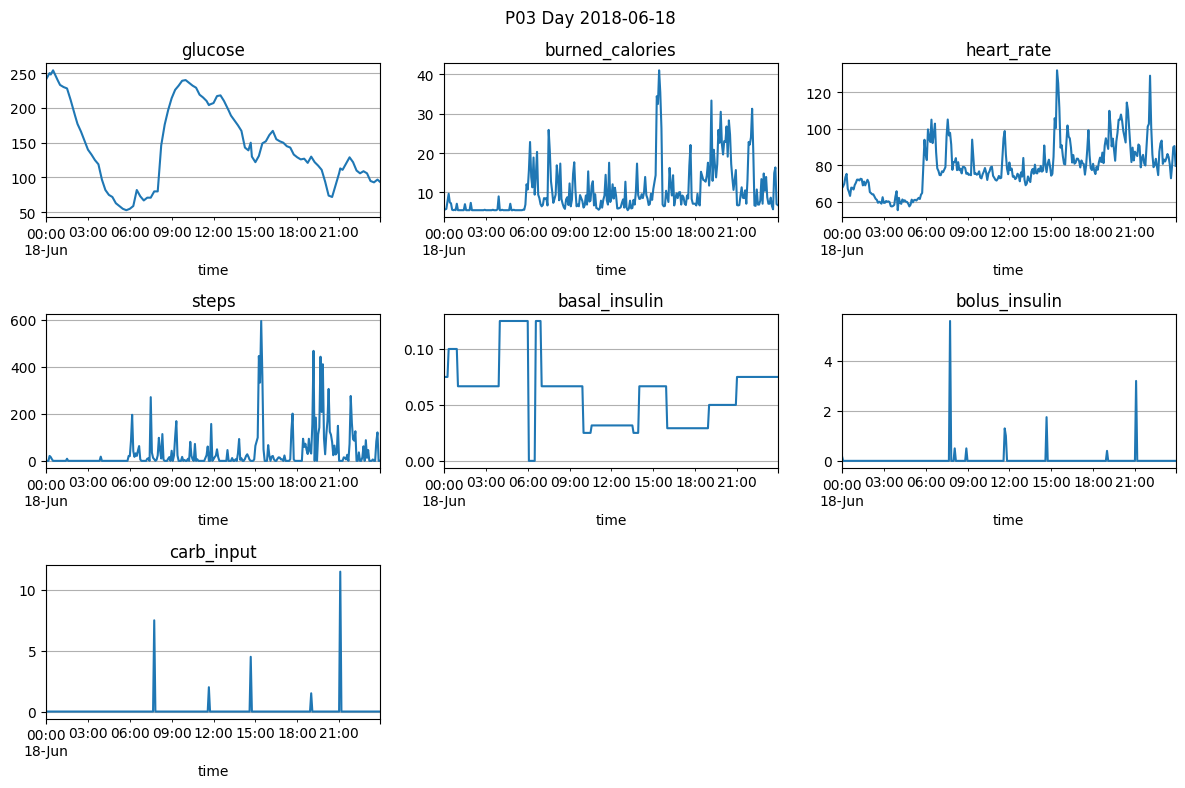

In [ ]:
# choose a random day to visualize
sample_day = random_day(subj)
subj_day = subj[subj.index.date == sample_day]

fig, axes = plt.subplots(3, 3, sharex=False, figsize=(12, 8))
axes = axes.flatten()

numeric_cols = subj.select_dtypes(include=['number']).columns.to_list()
for i, col in enumerate(numeric_cols):
    subj_day[col].plot(grid=True, ax=axes[i])
    axes[i].set_title(col)

# Hide unused axes
for ax in axes[len(numeric_cols):]:
    ax.axis('off')

fig.suptitle(f"{subj_id} Day {sample_day}")
plt.tight_layout()
plt.show()

It seem's like some of the variable are highly correlated. Let's look at a correlation plot!

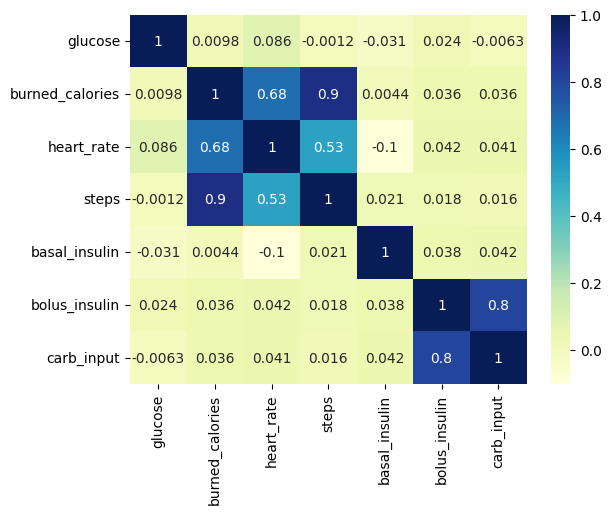

In [ ]:
dataplot = sns.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True)

Explaination:

The carb_input was measured by the glucose meter and used to determine the bolus_volume_delivered. \
Calories, heart_rate and steps were all measured using a fitness tracker. Calories were properly approximated using heart_rate and steps

### Interactive plots for further analysis

In [ ]:
subj_df = get_subj('P01')
cols = subj_df.select_dtypes(include=['number']).columns.to_list()

# different normalization can be pretty helpful to see dependencies between variables on different scales
# options: 'ZScore', 'MinMax', 'None'
show_interactive_ts_plot(subj_df, cols, normalization='MinMax')

Some findings:
- P01: wierd rippling effect in glucose levels -> smooth the curve
- P09: only limited insulin readings! DON'T USE!
- P26 -> long gap, bad carb tracking,
- P18: no insulin pump => no carb measurement / bolus volume

In [ ]:
subj_df = get_subj('P01')
#cols = subj_df.select_dtypes(include=['number']).columns.to_list()
cols = ['glucose', 'heart_rate', 'basal_insulin', 'bolus_insulin']
show_interactive_subplots(subj_df, cols)

## Intersubject analysis

How many timepoints to we have per subject?

In [ ]:
days_per_subj = df_all.groupby('subj').time.agg(lambda t: (t.max()-t.min()).days)
for k,v in days_per_subj.items():
    print(f"{k}: {v} days ({100*v/days_per_subj.sum():.2f}%)")

P01: 14 days (1.32%)
P02: 11 days (1.04%)
P03: 13 days (1.22%)
P04: 11 days (1.04%)
P05: 13 days (1.22%)
P06: 7 days (0.66%)
P07: 13 days (1.22%)
P09: 13 days (1.22%)
P10: 10 days (0.94%)
P11: 13 days (1.22%)
P14: 13 days (1.22%)
P15: 13 days (1.22%)
P16: 13 days (1.22%)
P17: 12 days (1.13%)
P18: 13 days (1.22%)
P19: 12 days (1.13%)
P20: 9 days (0.85%)
P21: 8 days (0.75%)
P22: 13 days (1.22%)
P23: 13 days (1.22%)
P24: 10 days (0.94%)
P25: 13 days (1.22%)
P26: 140 days (13.18%)
P27: 573 days (53.95%)
P28: 89 days (8.38%)


In [ ]:
big_subjs = ['P26','P27','P28']
print(f"{100*days_per_subj[days_per_subj.index.isin(big_subjs)].sum() / days_per_subj.sum():.2f}% of the data is from {big_subjs}")

"75.52% of the data is from ['P26', 'P27', 'P28']"

- Over 50% of the dataset is just one subject (P27)
- ~75% is from P26, P27 or P28
- all other just contribute ~1% each

In [ ]:
# calculate some avg day statistics for each subject
subj_statistics = df_all.groupby('subj').agg(['mean', 'min', 'max']).round(1)
# mean of day's total makes more sense for some of the variables
mean_day_total = df_all.groupby(['subj', pd.Grouper(key='time',freq='1D')]).sum().groupby(level='subj').agg(['mean', 'min', 'max']).round()

subj_statistics = pd.concat([subj_statistics[['glucose', 'heart_rate']],
                             mean_day_total[['steps', 'basal_insulin', 'bolus_insulin', 'burned_calories', 'carb_input']]],
                            axis=1)

display(subj_statistics.transpose())

subj                      P01      P02      P03      P04      P05      P06  \
glucose         mean    181.4    113.5    143.3    180.4    147.7    165.2   
                std      70.6     59.1     61.3     83.0     49.8     84.7   
                min      40.0     40.0     44.0     40.0     40.0     42.0   
                max     444.0    310.0    366.0    411.0    379.0    438.0   
heart_rate      mean     80.8     66.7     78.1     78.1     84.5     65.6   
                std      12.9     12.0     12.7      9.2     11.0     14.3   
                min      53.5     39.4     51.2     59.9     32.4     41.4   
                max     167.3    118.1    148.9    149.6    124.2    157.7   
steps           mean   5316.0  10402.0   7381.0   8147.0   3714.0   8653.0   
                min    1276.0      0.0    502.0   5235.0      0.0   5013.0   
                max   10918.0  14937.0  11875.0  10475.0  12831.0  12847.0   
basal_insulin   mean     14.0     23.0     15.0     19.0     18.0     19.0   
                min       3.0      1.0      2.0      8.0      8.0      8.0   
                max      16.0     26.0     18.0     23.0     19.0     23.0   
bolus_insulin   mean     11.0     19.0     19.0     40.0      7.0     25.0   
                min       4.0      8.0      0.0     14.0      4.0      7.0   
                max      15.0     34.0     28.0     49.0     11.0     36.0   
burned_calories mean   1617.0   2701.0   2509.0   2842.0   1531.0   2505.0   
                min     575.0     94.0    272.0   1352.0    860.0   1155.0   
                max    1979.0   3435.0   3031.0   3430.0   2127.0   3241.0   
carb_input      mean      8.0     53.0     31.0    168.0      6.0     25.0   
                min       4.0      0.0      0.0      0.0      3.0     12.0   
                max      12.0    135.0     40.0    320.0     10.0     37.0   

subj                      P07      P09      P10      P11  ...      P19  \
glucose         mean    173.2    193.7    135.9    159.1  ...    162.9   
                std      78.7     46.1     57.6     57.1  ...     60.5   
                min      40.0    100.0     41.0     53.0  ...     51.0   
                max     385.0    307.0    416.0    355.0  ...    371.0   
heart_rate      mean     70.2     84.6     78.2     73.8  ...     71.9   
                std      14.5     11.2     10.6     14.6  ...     19.7   
                min      43.9     61.9     53.5     49.0  ...     37.1   
                max     149.4    128.2    166.3    163.8  ...    163.2   
steps           mean  12680.0  12893.0  12072.0  14968.0  ...  12122.0   
                min    5811.0   7060.0   6235.0   5639.0  ...   3169.0   
                max   21282.0  17112.0  17877.0  21868.0  ...  24686.0   
basal_insulin   mean     22.0     24.0     16.0      0.0  ...     17.0   
                min      10.0     11.0      7.0      0.0  ...      7.0   
                max      24.0     26.0     21.0      0.0  ...     21.0   
bolus_insulin   mean     34.0      9.0      9.0      0.0  ...      4.0   
                min      21.0      5.0      4.0      0.0  ...      2.0   
                max      39.0     18.0     13.0      0.0  ...      6.0   
burned_calories mean   3835.0   2236.0   1954.0   2246.0  ...   2913.0   
                min    1656.0   1188.0    870.0    876.0  ...   1117.0   
                max    4796.0   2691.0   2363.0   2738.0  ...   4093.0   
carb_input      mean     20.0      4.0     10.0     80.0  ...      4.0   
                min      12.0      1.0      6.0     10.0  ...      1.0   
                max      24.0      6.0     13.0    130.0  ...      5.0   

subj                      P20      P21     P22     P23      P24      P25  \
glucose         mean    194.3    137.3   112.6   133.1    166.9    113.8   
                std      78.8     46.0    40.4    43.2     66.5     40.1   
                min      40.0     47.0    40.0    40.0     42.0     40.0   
                max     390.0    279.0   298.0

While this table is not really readable, we can some unexpected things for carb_input and bolus_insulin

In [ ]:
mean_day_total.loc[['P01','P02','P04','P15','P22'],['carb_input', 'bolus_insulin']]

carb_input               bolus_insulin            
           mean    min    max          mean   min   max
subj                                                   
P01         8.0    4.0   12.0          11.0   4.0  15.0
P02        53.0    0.0  135.0          19.0   8.0  34.0
P04       168.0    0.0  320.0          40.0  14.0  49.0
P15         0.0    0.0    0.0           0.0   0.0   0.0
P22       281.0  271.0  301.0          28.0  22.0  37.0

- Carb_input is not well tracked for all subjects and on different scales between subject
- bolus insulin is not tracked in some subjects

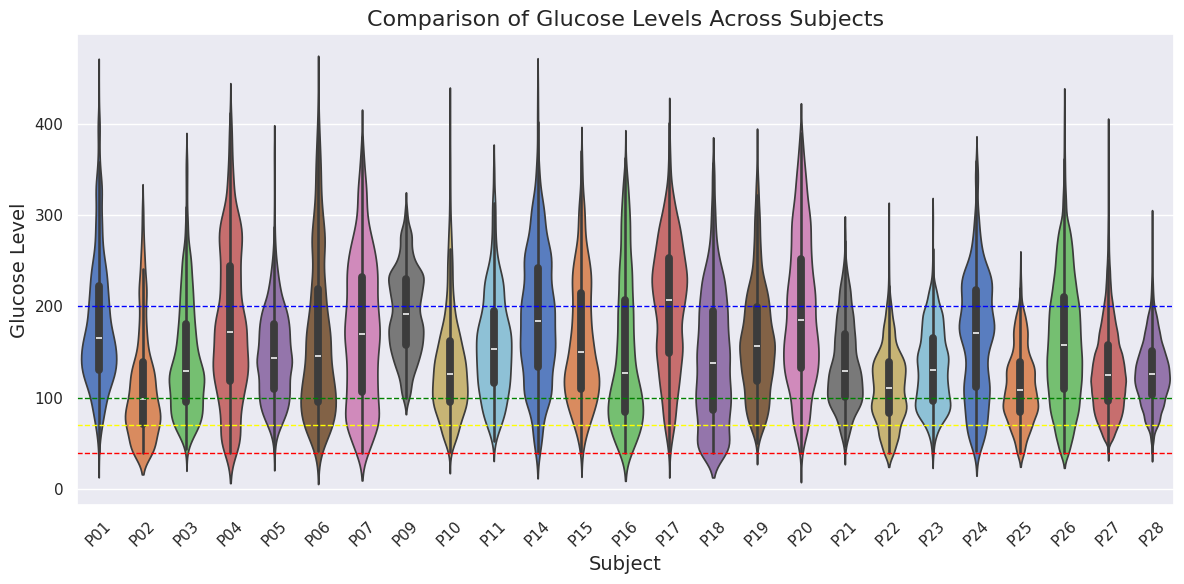

In [ ]:
# Create the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='subj', y='glucose', data=df_all, palette='muted', hue='subj')

# Add vertical lines at 40 and 200
plt.axhline(y=40, color='red', linestyle='--', linewidth=1, label='Threshold: 40 - critical')
plt.axhline(y=70, color='yellow', linestyle='--', linewidth=1, label='Threshold: 70 - harmful')
plt.axhline(y=100, color='green', linestyle='--', linewidth=1, label='Threshold: 100 - normal')
plt.axhline(y=200, color='blue', linestyle='--', linewidth=1, label='Threshold: 200 - high')

# Customize the plot
plt.title('Comparison of Glucose Levels Across Subjects', fontsize=16)
plt.xlabel('Subject', fontsize=14)
plt.ylabel('Glucose Level', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed for readability

# Show the plot
plt.tight_layout()
plt.show()

Yeah that are some pretty unhealthy levels of blood glucose ^^'

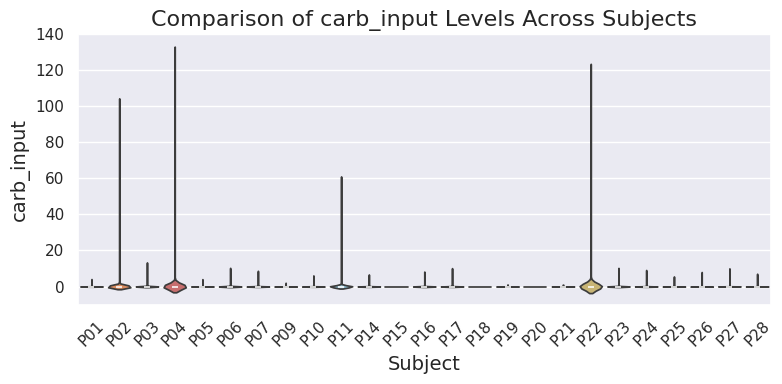

In [ ]:
var_name = 'carb_input'

plt.figure(figsize=(8, 4))
sns.violinplot(x='subj', y=var_name, data=df_all, palette='muted', hue='subj')

# Customize the plot
plt.title(f'Comparison of {var_name} Levels Across Subjects', fontsize=16)
plt.xlabel('Subject', fontsize=14)
plt.ylabel(var_name, fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels if needed for readability

# Show the plot
plt.tight_layout()
plt.show()

This show cases the scale difference for carb_input pretty well. Hard to use this feature...

# Preprocessing

We are about to:
- remove 'burned_calories', 'steps', 'carb_input' from the feature list, because they are multicolinear or just bad
- remove Subject P09, because his/her glucose data is really bad
- smooth the glucose data for subject P01 to remove the rippling effect
- add time features for hour of day, since the circadiane rhythm most likely has some influence (like being awake/sleeping)

In [ ]:
df = df_all.copy().drop(columns=['burned_calories', 'steps', 'carb_input'])
# Remove Subject P09, because glucose data is bad
df = df.drop(index=df[(df['subj'] == 'P09')].index)
# smooth glucose data for subject P01 to remove rippling effect
df.loc[df.subj == 'P01', 'glucose'] = df.loc[df.subj == 'P01', 'glucose'].rolling(3, center=True).mean()
df = df.set_index('time')
# add time features
df['hour_of_day'] = df.index.hour
df['hour_sin'] = np.sin(np.pi * df.index.hour / 12)
df['hour_cos'] = np.cos(np.pi * df.index.hour / 12)
df.round(3).head()

,subj,glucose,heart_rate,basal_insulin,bolus_insulin,hour_of_day,hour_sin,hour_cos
time,,,,,,,,
2018-06-13 18:40:00,P01,NaN,82.323,0.092,0.0,18,-1.000,-0.000
2018-06-13 18:45:00,P01,329.333,83.740,0.092,0.0,18,-1.000,-0.000
2018-06-13 18:50:00,P01,326.667,80.525,0.092,0.0,18,-1.000,-0.000
2018-06-13 18:55:00,P01,320.000,89.129,0.092,0.0,18,-1.000,-0.000
2018-06-13 19:00:00,P01,314.333,92.496,0.075,0.0,19,-0.966,0.259


The data was preprocessed and some (big) gaps were linearly interpolated. Especially for glucose and heart rate this does not seem like the best method. So we detect these periods (using a threshold on the second derivative) and mask them.

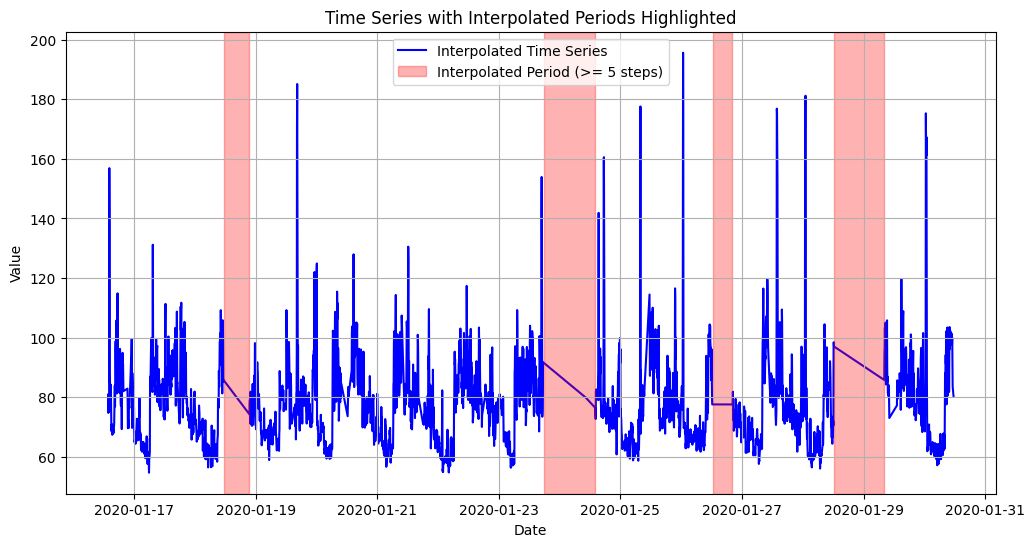

In [ ]:
ts = df[df.subj == 'P25'].heart_rate
mask = approx_interpolated_periods(ts, 12*3, 0.1, smoothing_win=3)
plot_gaps(ts, mask)

In [ ]:
# for small gaps the linear interpolation is propably fine
min_gap_len = 12*5

df_gaps = df.copy()
for s in df_gaps.subj.unique():
    df_sub = df_gaps[df.subj == s]
    glucose_mask = approx_interpolated_periods(df_sub['glucose'], min_length=min_gap_len, smoothing_win=3)
    if glucose_mask.sum() > 0:
        #print(f"Replace {glucose_mask.sum()} BG values with nan for subject {s}")
        df_sub.loc[glucose_mask, 'glucose'] = np.nan
    hr_mask = approx_interpolated_periods(df_sub['heart_rate'], min_length=min_gap_len,
                                          eps=.1, smoothing_win=3)
    if hr_mask.sum() > 0:
        #print(f"Replace {hr_mask.sum()} HR values with nan for subject {s}")
        df_sub.loc[hr_mask, 'heart_rate'] = np.nan

    df_gaps[df.subj == s] = df_sub
#print(df.isna().sum())

In [ ]:
gaps_info = df_gaps[['glucose', 'heart_rate']].isna().groupby(df_gaps.subj).agg(
    [('[#]', 'sum'), ('[%]', lambda x: 100*x.sum()/len(x))])
gaps_info.round(1)#.reorder_levels([1,0], axis=1)

glucose       heart_rate      
         [#]   [%]        [#]   [%]
subj                               
P01        2   0.0         63   1.5
P02       60   1.9          0   0.0
P03        0   0.0        189   5.0
P04      294   9.2       1389  43.6
P05        0   0.0       1593  41.3
P06        0   0.0          0   0.0
P07        0   0.0          0   0.0
P10      587  19.7       1277  42.9
P11        0   0.0          0   0.0
P14      531  13.9        195   5.1
P15        0   0.0          0   0.0
P16      282   7.4          0   0.0
P17       87   2.4        130   3.6
P18        0   0.0          0   0.0
P19        0   0.0        259   7.0
P20        0   0.0         87   3.0
P21        0   0.0          0   0.0
P22      143   3.6          0   0.0
P23        0   0.0          0   0.0
P24        0   0.0          0   0.0
P25        0   0.0        696  17.4
P26     3918   9.6       2097   5.2
P27     7776   4.7      24518  14.8
P28      546   2.1        871   3.4

Seems like some subjects did not use the heart rate monitor correctly..

Let's visualize the results:

In [ ]:
id = 'P04'
temp_df = pd.concat([get_subj(id, df)[['glucose', 'heart_rate']],
                     get_subj(id, df_gaps)[['glucose', 'heart_rate']].add_suffix('_post')],
                    axis=1)
temp_df = temp_df.reindex(sorted(temp_df.columns), axis=1)

show_interactive_ts_plot(temp_df, temp_df.columns)

In [ ]:
_df = df_gaps

subj_list = _df.subj.unique().tolist()
#test_subjs = subj_list[:7]
#train_subjs = subj_list[7:]

test_subjs = [f'P{x:02d}' for x in [6, 7, 11, 15, 18, 21]] # use a curated list of high quality data as test set ;)
train_subjs = [x for x in subj_list if x not in test_subjs and x != 'P27']
print(f'Train subjects ({100 * _df.subj.isin(train_subjs).sum() / len(_df) :.2f}%): {train_subjs}')
print(f'Test subjects ({100 * _df.subj.isin(test_subjs).sum() / len(_df) :.2f}%): {test_subjs}')

train_multi = _df.loc[df.subj.isin(train_subjs)]
test_multi = _df.loc[df.subj.isin(test_subjs)]

p27 = get_subj('P27', _df)
ratio = 0.8
train_p27 = p27.iloc[:int(ratio*len(p27))]
test_p27 = p27.iloc[int(ratio*len(p27)):]

print(f'Train P27 ({100 * len(train_p27) / len(_df) :.2f}%)')
print(f'Test P27 ({100 * len(test_p27) / len(_df) :.2f}%)')

Train subjects (39.35%): ['P01', 'P02', 'P03', 'P04', 'P05', 'P10', 'P14', 'P16', 'P17', 'P19', 'P20', 'P22', 'P23', 'P24', 'P25', 'P26', 'P28']
Test subjects (6.55%): ['P06', 'P07', 'P11', 'P15', 'P18', 'P21']
Train P27 (43.28%)
Test P27 (10.82%)


In [ ]:
# Save as csv
train_multi.to_csv('Data/train_multi.csv')
test_multi.to_csv('Data/test_multi.csv')
train_p27.to_csv('Data/train_p27.csv')
test_p27.to_csv('Data/test_p27.csv')